# 1. Load cropped

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import torchvision.transforms as transforms
import math
import itertools
from torch import nn as nn
import torch.nn.functional as F
from torch import Tensor
from numpy.matlib import repmat
import torch.optim as optim
from collections import OrderedDict
import cv2
import wandb
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
import random


def load_cropped(folder_path, csv_path, patient_list = [], sample_size=200):
    # Cargar el CSV con pandas
    df = pd.read_csv(csv_path)
    
    # Convertir el CSV a un diccionario para un acceso rápido
    patient_metadata = {row['CODI']: row['DENSITAT'] for _, row in df.iterrows()}

    # Inicializar la estructura de datos para almacenar los datos de los pacientes seleccionados
    patients_data = []
    images_list = []

    # si no se proporciona una lista de pacientes, se seleccionan todos los pacientes iterando folder_path
    if not patient_list:
        for patient_folder in glob.glob(os.path.join(folder_path, "*")):
            patient_id = os.path.basename(patient_folder).split("_")[0]
            patient_list.append(patient_id)
    
    incorrect_shape = 0
    # Iterar sobre cada paciente en la lista de IDs proporcionada
    for i,patient_id in enumerate(patient_list):
        print('--- Loading data from patient:', patient_id, f'(--- {i+1}/{len(patient_list)}) ---')
        # Obtener carpeta del paciente
        try:
            patient_folder = glob.glob(os.path.join(folder_path, f"{patient_id}_*"))[0]
        except:
            print(f'Patient {patient_id} not found in the dataset folder')
            continue

        # Verificar que el paciente esté en el CSV
        if patient_id in patient_metadata:
            # Obtener todas las imágenes .png dentro de la carpeta del paciente
            images = glob.glob(os.path.join(patient_folder, "*.png"))
            
            # Si el paciente tiene imágenes en su carpeta
            if images:
                # Mezclar la lista de imágenes
                random.shuffle(images)
                
                # Seleccionar una muestra de tamaño sample_size o menos si hay menos imágenes
                images_sampled = random.sample(images, min(sample_size, len(images)))
                
                for j,image_path in enumerate(images_sampled):
                    if j % 100 == 0:
                        print(f'------ Loading image {j}/{len(images_sampled)} ---')

                    # Cargar la imagen en formato BGR con cv2
                    image_bgr = cv2.imread(image_path)
                    
                    # Convertir la imagen de BGR a RGB
                    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

                    if image_rgb.shape[0] != 256 or image_rgb.shape[1] != 256:
                        incorrect_shape +=1
                        # Resize de la imagen a 256x256
                        image_rgb = cv2.resize(image_rgb, (256, 256))

                    # Permutar canales
                    image_rgb = np.transpose(image_rgb, (2, 0, 1))

                    # Pasar de uint8 a float32
                    image_rgb = image_rgb/255.0
                    
                    # Añadir la imagen a la lista de imágenes en formato RGB
                    images_list.append(image_rgb)
                # Binariar densidad
                if patient_metadata[patient_id] == "NEGATIVA":
                    dens = 0
                else:
                    dens = 1
                
                # Añadir la densidad a la lista de metadatos
                patients_data.extend([dens] * len(images_sampled))

    print(f'Resized images: {incorrect_shape}/{len(images_list)}')
    
    return images_list, patients_data

# Paso 2: Crear la clase Standard_Dataset
class Standard_Dataset(data.Dataset):
    def __init__(self, X, Y=None, transformation=None):
        super().__init__()
        self.X = X
        self.y = Y
        self.transformation = transformation
 
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        if self.transformation:
            image = self.transformation(image)
            
        image_tensor = torch.from_numpy(image).float()
        
        if self.y is not None:
            label = torch.tensor(self.y[idx], dtype=torch.float32)
            return image_tensor, label
        else:
            return image_tensor

# Paso 3: Cargar los datos
folder_path = "C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Cropped_sample"
csv_path = "C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/PatientDiagnosis.csv"
patient_list = ['B22-25']
sample_size = 1

# Filtrando imágenes y etiquetas para obtener solo aquellas cuya densidad es 0
images, labels = load_cropped(folder_path, csv_path, patient_list, sample_size)



## 2. AUTOENCODER

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def init_weights_transformer(module,InitParams):
    Type=InitParams['Type']
    U=InitParams['U']
    
    if Type=='ori':
        init_weights_transformer_ori(module)
    elif Type=='all':
        init_weights_transformer_all(module,U)       
    else:
        init_weights_transformer_exceptnorm(module,U) 
    
def init_weights_transformer_all(module,U=[0,1]):
    param=module.state_dict()
   
    for name in param.keys():
        if name.find('norm')<0:
           nn.init.uniform_(param[name],a=U[0],b=U[1])

                
def init_weights_transformer_exceptnorm(module,U=[0,1]):
    param=module.state_dict()
   
    for name in param.keys():
        if name.find('norm')<0:
           if (name.find('weight')>0):
                nn.init.uniform_(param[name],a=U[0],b=U[1])
           elif (name.find('bias')>0):
                nn.init.constant_(param[name], 0)
    #        
def init_weights_transformer_ori(module):
    initrange = 0.1
    nn.init.uniform_(module.encoder.weight, -initrange, initrange)
    nn.init.zeros_(module.decoder1[0].bias)
    nn.init.zeros_(module.decoder2.bias)
    nn.init.uniform_(module.decoder1[0].weight, -initrange, initrange)
    nn.init.uniform_(module.decoder2.weight, -initrange, initrange)
    

def init_weights_xavier_normal(module):
    for m in module.modules():
        if isinstance(m, nn.Conv1d):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv3d):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LSTM):
            for param in m.parameters():
                if len(param.shape) >= 2:
                    nn.init.orthogonal_(param.data)
                else:
                    nn.init.normal_(param.data)

def init_weights_xavier_uniform(module):
    for m in module.modules():
        if isinstance(m, nn.Conv1d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv3d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LSTM):
            for param in m.parameters():
                if len(param.shape) >= 2:
                    nn.init.orthogonal_(param.data)
                else:
                    nn.init.uniform_(param.data)

def init_weights_kaiming_uniform(module):
    for m in module.modules():
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv3d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.uniform_(m.weight, a=0, b=1)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

def init_weights_kaiming_normal(module):
    for m in module.modules():
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, val=0.)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, val=0.)

In [4]:
### Linear FC Blocks
def linear_block(n_inputs_loc, hidden_loc, 
                 activ_config=None,batch_config=None,p_drop_loc=0.1): 
    
    # Dictionary defining Block Architecture
    BlockArchitecture=[]
   
    hidden_loc.insert(0,n_inputs_loc)
  
    if activ_config==None:
        activ_config=repmat('no_activ',len(hidden_loc),1)
    if batch_config==None:
        batch_config=repmat('no_batch',len(hidden_loc),1)
    #Block Layers List
    for i in np.arange(len(hidden_loc)-1):
        BlockArchitecture.append(('linear'+str(i+1),
                                  nn.Linear(hidden_loc[i], hidden_loc[i+1])))
        
        if(activ_config[i]=='relu'):
            BlockArchitecture.append(('relu'+str(i+1),nn.ReLU(inplace=True)))
           
        elif(activ_config[i]=='tanh'):
            BlockArchitecture.append(('tanh'+str(i+1),nn.Tanh()))
        elif(activ_config[i]=='relu6'):
             BlockArchitecture.append(('relu6'+str(i+1),nn.ReLU6(inplace=True)))
             
        if(batch_config[i]=='batch'):
            BlockArchitecture.append(('batch'+str(i+1),nn.BatchNorm1d( hidden_loc[i+1])))
         
        BlockArchitecture.append(('drop'+str(i+1),nn.Dropout(p_drop_loc)))  
    linear_block_loc = nn.Sequential(
        OrderedDict(BlockArchitecture)
        )
    return linear_block_loc


class LinearBlock(nn.Module):
    """
    MultiLayer Perceptron: 
    Netwotk with n_hidden layers with architecture linear+drop+relu+batch
     Constructor Parameters:
           n_inputs: dimensionality of input features (n_channels * n_features , by default) 
                     n_channels (=14), number of sensors or images for each case
                     n_features(=40), number of features for each n_channels
           n_classes: number of output classes (=3, by default)
           hidden(=[128,128], default): list with the number of neurons for each hidden layer
           p_drop(=0.1, default): probability for Drop layer (=0, no drop is performed)

    """
    
    def __init__(self, inputmodule_params,net_params):
        super().__init__()

        
       
        ### Input Parameters
        self.n_inputs = inputmodule_params['n_inputs']

       
        self.hidden=net_params['hidden']
        self.dropout=net_params['dropout']
        if net_params['dropout'] is None:
            self.dropout=0.5
        self.nlayers=len(self.hidden)
        if 'activ_config' not in list(net_params.keys()):
    
            self.activ_config=None
        else:
             self.activ_config=net_params['activ_config']
        
        if 'batch_config' not in list(net_params.keys()):
            self.batch_config=None
        else:
            self.batch_config=net_params['batch_config']
             
              
        
        self.linear_block0= linear_block(self.n_inputs, self.hidden.copy(), 
                                                 activ_config=self.activ_config, 
                                                 batch_config=self.batch_config,
                                                 p_drop_loc=self.dropout)

       
        
      #  self.fc_out=nn.Identity()
        # weight init
        init_weights_xavier_normal(self)

    def forward(self, x):
              
      
        return self.linear_block0(x)

### Convolutional 
class _CNNLayer(nn.Module):
    def __init__(
        self, num_input_features: int, n_neurons: int, kernel_sze:int =3, 
        stride:int=1,
        drop_rate: float=0,
        Relu=True
         ) -> None:
        super().__init__()
        

        norm1 = nn.BatchNorm2d(n_neurons)
        conv1 = nn.Conv2d(num_input_features, n_neurons, kernel_size=kernel_sze,  
                               stride=stride, padding=(int((kernel_sze-1)/2)))

      #  relu1 = nn.ReLU(inplace=True)
        relu1= nn.LeakyReLU(inplace=True)

        drop=nn.Dropout(drop_rate)
        if Relu:
            self.cnn_layer=nn.Sequential(conv1,norm1,relu1,drop)
        else:
            self.cnn_layer=nn.Sequential(conv1,norm1,drop)
        init_weights_xavier_normal(self)
        
    def forward(self, x: Tensor):
         
        return(self.cnn_layer(x))

class _UnCNNLayer(nn.Module):
    def __init__(
        self, num_input_features: int, n_neurons: int, kernel_sze:int =3, 
        stride:int=2,
        drop_rate: float=0, 
        Relu=True
         ) -> None:
        super().__init__()
        
        self.stride=stride
        norm1 = nn.BatchNorm2d(n_neurons)
        conv1 = nn.ConvTranspose2d(num_input_features, n_neurons, kernel_size=kernel_sze,  
                               stride=stride, padding=(int((kernel_sze-1)/2)))

        
     #   relu1 = nn.ReLU(inplace=True)
        relu1 = nn.LeakyReLU(inplace=True)

        drop=nn.Dropout(drop_rate)
        if Relu:
            self.cnn_layer=nn.Sequential(conv1,norm1,relu1,drop)
        else:
            self.cnn_layer=nn.Sequential(conv1,norm1,drop)
        init_weights_xavier_normal(self)
        
    def forward(self, x: Tensor):
        
        if  self.stride>1:
            sze_enc=x.shape[-1]
            x=self.cnn_layer[0](x,output_size=(sze_enc*2,sze_enc*2))
            for k in np.arange(1,len(self.cnn_layer)):
                x=self.cnn_layer[k](x)
        else:
            x=self.cnn_layer(x)
            
        return(x)
    
    # def forward(self, x1, x2):
    #     x1 = self.cnn_layer(x1)
    #     # input is CHW
    #     diffY = x2.size()[2] - x1.size()[2]
    #     diffX = x2.size()[3] - x1.size()[3]

    #     x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
    #                     diffY // 2, diffY - diffY // 2])
    #     # if you have padding issues, see
    #     # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
    #     # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
    #     x = torch.cat([x2, x1], dim=1)
    #     return self.conv(x)
    
class _CNNBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_input_channels: int=1,
        drop_rate=0,
        block_config = (64,128),
        stride=None,
        decoder=False,
        Relu=True
    
    ) -> None:
        super().__init__()
        
        num_layers=len(block_config)
        self.num_input_channels=num_input_channels
        print('block inp ch',num_input_channels)
        
        if stride is None:
            stride=np.ones(num_layers)
            
        for i in range(num_layers):
            if decoder==True:
                layer = _UnCNNLayer(
                    num_input_channels,
                    n_neurons=block_config[i],
                    stride=stride[i],
                    drop_rate=drop_rate
                    
                )
            else:
                layer = _CNNLayer(
                    num_input_channels,
                    n_neurons=block_config[i],
                    stride=stride[i],
                    drop_rate=drop_rate, 
                    Relu=Relu
                    
                )
            self.add_module("cnnlayer%d" % (i + 1), layer)
            num_input_channels=block_config[i]

    def forward(self, x: Tensor) -> Tensor:
        
        for name, layer in self.items():
            x = layer(x)
            
            
        return x



In [5]:

#  BACKBONE MODULES 
class Encoder(nn.Module):
    r"""Encoder class
    `".
    Input Parameters:
        1. inputmodule_params: dictionary with keys ['num_input_channels']
            inputmodule_params['num_input_channels']=Channels of input images
        2. net_params: dictionary defining architecture: 
            net_params['block_configs']: list of number of neurons for each 
            convolutional block. A block can have more than one layer
            net_params['stride']:list of strides for each block layers
            net_params['drop_rate']: value of the Dropout (equal for all blocks)
        Examples: 
            1. Encoder with 4 blocks with one layer each
            net_params['block_configs']=[[32],[64],[128],[256]]
            net_params['stride']=[[2],[2],[2],[2]]
            2. Encoder with 2 blocks with two layers each
            net_params['block_configs']=[[32,32],[64,64]]
            net_params['stride']=[[1,2],[1,2]]
            
    """

    def __init__(self, inputmodule_params,net_params):
        super().__init__()
        
        
        num_input_channels=inputmodule_params['num_input_channels']
        

            
        drop_rate=net_params['drop_rate']
        block_configs=net_params['block_configs'].copy()
        n_blocks=len(block_configs)
        if 'stride' in net_params.keys():
            stride=net_params['stride']
        else:
            stride=[]
            for i in np.arange(len(block_configs)):
                stride.append(list(np.ones(len(block_configs[i])-1,dtype=int))+[2])
                
        # Encoder
        self.encoder=nn.Sequential(          
            )
        outchannels_encoder=[]
        for i in np.arange(n_blocks):
            print('block',i)
            block = _CNNBlock(
                num_input_channels=num_input_channels,
                drop_rate=drop_rate,
                block_config=block_configs[i],
                stride= stride[i]               
                
            )
            self.encoder.add_module("cnnblock%d" % (i + 1), block)
            
            if stride==1:
                self.encoder.add_module("mxpool%d" % (i + 1), 
                                         nn.MaxPool2d(kernel_size=2, stride=2, padding=0))

            num_input_channels=block_configs[i][-1] 
           # outchannels_encoder.append(num_input_channels)
           
          
               
    def forward(self, x: Tensor) -> Tensor:
        
        x=self.encoder(x)

        return x

class Decoder(nn.Module):
    r"""Decoder class
    `".
    Input Parameters:
        1. inputmodule_params: dictionary with keys ['num_input_channels']
            inputmodule_params['num_input_channels']=Channels of input images
        2. net_params: dictionary defining architecture: 
            net_params['block_configs']: list of number of neurons for each conv block
            net_params['stride']:list of strides for each block layers
            net_params['drop_rate']: value of the Dropout (equal for all blocks)
    """
    def __init__(self, inputmodule_params,net_params):
        super().__init__()
        
   
        num_input_channels=inputmodule_params['num_input_channels']
        
        self.upPoolMode='bilinear'

            
        drop_rate=net_params['drop_rate']
        block_configs=net_params['block_configs'].copy()
        self.n_blocks=len(block_configs)
        
        if 'stride' in net_params.keys():
            stride=net_params['stride']
        else:
            stride=[]
            for i in np.arange(len(block_configs)):
                stride.append(list(np.ones(len(block_configs[i])-1,dtype=int))+[2])
                

        # Decoder
        self.decoder=nn.Sequential(          
            )
        
        for i0 in np.arange(self.n_blocks)[::-1]:
            i=self.n_blocks-(i0+1)
            block = _CNNBlock(
                num_input_channels=num_input_channels,
                drop_rate=drop_rate,
                block_config=block_configs[i], 
                stride=stride[i],
                decoder=True
            )
            
            # if stride==1:
            #     self.decoder.add_module("uppool%d" % (i + 1), 
            #                               nn.Upsample(scale_factor=2, 
            #                                           mode=self.upPoolMode, align_corners=True))
            
            self.decoder.add_module("cnnblock%d" % (i0+1), block)
      

            num_input_channels=block_configs[i][-1]
        
        
        self.decoder[-1][list(self.decoder[-1].keys())[-1]].cnn_layer[2]=nn.Identity()
        
    def forward(self, x: Tensor) -> Tensor:
        
        input_sze=x.shape

     #   for i in np.arange(n_blocks)[::-1]:
            
        x=self.decoder(x)
    
        return x

##### GENERATIVE MODELS 
class AutoEncoderCNN(nn.Module):
    r"""AutoEncoderCNN model class
    `".
    Input Parameters:
        1. inputmodule_paramsEnc: dictionary with keys ['num_input_channels']
            inputmodule_paramsEnc['num_input_channels']=Channels of input images
        2. net_paramsEnc: dictionary defining architecture of the Encoder (see Encoder class) 
        3. inputmodule_paramsDec: dictionary with keys ['num_input_channels']
           inputmodule_paramsDec['num_input_channels']=Channels of input images
        4. net_paramsDec: dictionary defining architecture of the Encoder (see Decoder/Encoder classes) 
    """

    def __init__(self, inputmodule_paramsEnc,net_paramsEnc,inputmodule_paramsDec,net_paramsDec):
        super().__init__()
 
        self.inputmodule_paramsEnc=inputmodule_paramsEnc
        self.inputmodule_paramsDec=inputmodule_paramsDec
        self.net_paramsEnc=net_paramsEnc
        self.net_paramsDec=net_paramsDec

        # Encoder
        self.encoder=Encoder(inputmodule_paramsEnc,net_paramsEnc)
     
        # Decoder
        self.decoder=Decoder(inputmodule_paramsDec,net_paramsDec)
        
    def forward(self, x: Tensor) -> Tensor:
            # Guardamos el tamaño de la imagen de entrada para usarlo al final (en la fase de upsampling)
            input_size = x.shape

            # Paso por el Encoder
            encoded = self.encoder(x)
            
            # Paso por el Decoder
            decoded = self.decoder(encoded)
            
            return decoded


## 3. TRAIN

In [6]:
# Filtrando imágenes y etiquetas para obtener solo aquellas cuya densidad es 0
images, labels = load_cropped(folder_path, csv_path, patient_list, sample_size)
filtered_images = [img for img, label in zip(images, labels) if label == 0]
filtered_labels = [label for label in labels if label == 0]

# Crear el Dataset y DataLoader solo con las imágenes de densidad 0
filtered_dataset_train = Standard_Dataset(filtered_images)
dataloader_train = DataLoader(filtered_dataset_train, batch_size=32, shuffle=True)

In [7]:
def AEConfigs(Config):
    
    if Config=='1':
        # CONFIG1
        net_paramsEnc['block_configs']=[[32,32],[64,64]]
        net_paramsEnc['stride']=[[1,2],[1,2]]
        net_paramsEnc['drop_rate']=0.1
        net_paramsDec['drop_rate']=0.1
        net_paramsDec['block_configs']=[[64,32],[32,inputmodule_paramsEnc['num_input_channels']]]
        net_paramsDec['stride']=net_paramsEnc['stride']
        inputmodule_paramsDec['num_input_channels']=net_paramsEnc['block_configs'][-1][-1]
     

        
    elif Config=='2':
        # CONFIG 2
        net_paramsEnc['block_configs']=[[32],[64],[128],[256]]
        net_paramsEnc['stride']=[[2],[2],[2],[2]]
        net_paramsDec['block_configs']=[[128],[64],[32],[inputmodule_paramsEnc['num_input_channels']]]
        net_paramsDec['stride']=net_paramsEnc['stride']
        inputmodule_paramsDec['num_input_channels']=net_paramsEnc['block_configs'][-1][-1]
   
        
    elif Config=='3':  
        # CONFIG3
        net_paramsEnc['block_configs']=[[32],[64],[64]]
        net_paramsEnc['stride']=[[1],[2],[2]]
        net_paramsDec['block_configs']=[[64],[32],[inputmodule_paramsEnc['num_input_channels']]]
        net_paramsDec['stride']=net_paramsEnc['stride']
        inputmodule_paramsDec['num_input_channels']=net_paramsEnc['block_configs'][-1][-1]
    
    return net_paramsEnc,net_paramsDec,inputmodule_paramsDec


######################### 0. EXPERIMENT PARAMETERS

# 0.2 Parámetros y definiciones de red
inputmodule_paramsEnc = {'num_input_channels': 3}
net_paramsEnc = {}
net_paramsDec = {}
inputmodule_paramsDec = {}

# 0.1 AE PARAMETERS
inputmodule_paramsEnc={}
inputmodule_paramsEnc['num_input_channels']=3

###### CONFIG1
Config='1'
net_paramsEnc,net_paramsDec,inputmodule_paramsDec=AEConfigs(Config)
model=AutoEncoderCNN(inputmodule_paramsEnc, net_paramsEnc,
                     inputmodule_paramsDec, net_paramsDec)

block 0
block inp ch 3
block 1
block inp ch 32
block inp ch 64
block inp ch 32


In [8]:

# import torch
# import torch.optim as optim
# import torch.nn.functional as F
# from tqdm import tqdm

# # Hiperparámetros del entrenamiento
# num_epochs = 10  # Número de épocas de entrenamiento
# learning_rate = 0.001  # Tasa de aprendizaje

# # Definir el optimizador (en este caso, Adam)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Definir la función de pérdida (MSE)
# criterion = nn.MSELoss()

# # Enviar el modelo a la GPU si está disponible
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Bucle de entrenamiento
# for epoch in range(num_epochs):
#     model.train()  # Poner el modelo en modo de entrenamiento
#     running_loss = 0.0  # Para almacenar la pérdida de cada época

#     # Iterar sobre el dataloader
#     for batch_idx, images in enumerate(tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs}")):
#         # Enviar los datos a la GPU si está disponible
#         images=images.permute(0,3,1,2) # permute images
#         images = images.to(device)
        
#         # Inicializar el gradiente a cero
#         optimizer.zero_grad()
        
#         # Paso forward
#         outputs = model(images)
        
#         # Calcular la pérdida
#         loss = criterion(outputs, images)
        
#         # Paso backward (retropropagación)
#         loss.backward()
        
#         # Actualizar los pesos
#         optimizer.step()
        
#         # Acumular la pérdida
#         running_loss += loss.item()
    
#     # Imprimir la pérdida promedio de cada época
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader_train)}")

In [25]:
!pip install wandb


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip install wandb


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import wandb

# Login
wandb.login(key='a14c6a2ec25620e6e2047f787c8dbe5d7710eaef')

# Inicia sesión en Weights & Biases y configura el experimento
wandb.init(
    project="repte3",    # Reemplaza con el nombre de tu proyecto
    entity="andreu-mir",      # Nombre del equipo
    name="test",    # Opcional: nombre específico para esta ejecución
    config={                          # Diccionario de configuraciones personalizadas
        "learning_rate": 0.01,
        "batch_size": 32,
        "num_epochs": 45,
        "model_architecture": "AutoEncoderCNN",
        "optimizer": "Adam"
    }
)

# Accede a los parámetros configurados como un diccionario
config = wandb.config
print("Learning rate configurado:", config.learning_rate)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\mirvi\.netrc


Learning rate configurado: 0.01


In [10]:
wandb.finish()

In [12]:
for batch_idx, images in enumerate(dataloader_train):
    print(images.shape)  # Añadir esta línea para ver la forma de las imágenes
    break


torch.Size([32, 3, 256, 256])


## 4. FRED THRESHOD

In [28]:
# load model
model = AutoEncoderCNN(inputmodule_paramsEnc, net_paramsEnc,
                     inputmodule_paramsDec, net_paramsDec)
model.load_state_dict(torch.load('C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/AutoEncoder/Best_Models/best_model_AECNN3_20.pth'))

block 0
block inp ch 3
block 1
block inp ch 32
block inp ch 64
block inp ch 32


C:\Users\mirvi\AppData\Local\Temp\ipykernel_13228\325970032.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Users/mirvi/Desktop/mii/

<All keys matched successfully>

### 4.1 Visualitzem outputs

In [31]:
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# Configurar el modelo en modo de evaluación
model.eval()

# Cargar y preprocesar una imagen
image_path = "C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Annotated/B22-26_0/01044.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB (OpenCV usa BGR por defecto)

# Transformar la imagen (debe coincidir con lo que usaste en el entrenamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),        # Convertir de numpy a imagen PIL
    transforms.Resize((256, 256)), # Redimensionar si fue así en el entrenamiento
    transforms.ToTensor()          # Convertir a tensor
])

image_tensor = transform(image).unsqueeze(0)  # Añadir dimensión de batch

# Pasar la imagen por el modelo
with torch.no_grad():
    # normalizar pixeles
    reconstructed = model(image_tensor)

# Reescalar la imagen para visualizarla
reconstructed = reconstructed.squeeze(0)  # Eliminar dimensión de batch
reconstructed = reconstructed.permute(1, 2, 0)  # Permutar canales



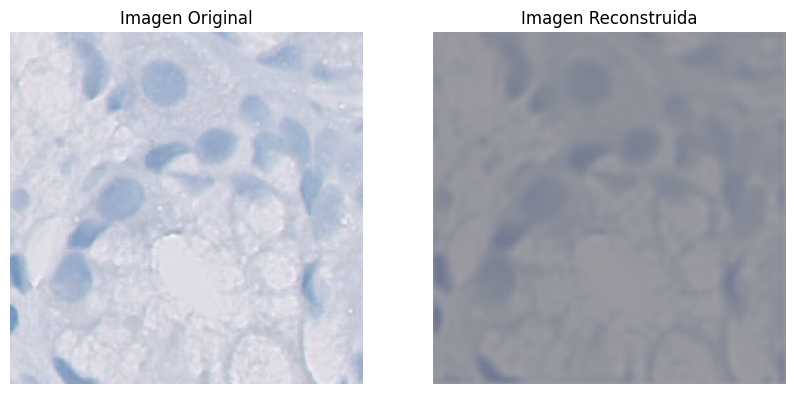

In [33]:
# Visualizar las imágenes
plt.figure(figsize=(10, 5))

# Imagen original
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Imagen Original")
plt.axis("off")

# Imagen reconstruida
plt.subplot(1, 2, 2)
plt.imshow(reconstructed)
plt.title("Imagen Reconstruida")
plt.axis("off")

plt.show()

### 4.2 Load Annotated

In [12]:
from torchvision import transforms
import torch
import numpy as np
from PIL import Image
from torch.utils import data

class Standard_Dataset(data.Dataset):
    def __init__(self, X, Y=None, transformation=None):
        super().__init__()
        self.X = X
        self.y = Y
        self.transformation = transformation

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Obtener la imagen
        image = self.X[idx]
        
        if self.transformation:
            # Convertir la imagen de numpy a PIL
            image = Image.fromarray(image.astype(np.uint8))

            # Aplicar la transformación (resize, etc.)
            image = self.transformation(image)

            # Convertir la imagen transformada de PIL a numpy
            image = np.array(image)
            
            # Normalizar la imagen (a valores de [0, 1])
            image = image / 255.0

        # Convertir la imagen numpy a tensor
        image_tensor = torch.from_numpy(image).float()
        
        if self.y is not None:
            # Si hay etiquetas, devolverlas junto con la imagen
            label = torch.tensor(self.y[idx], dtype=torch.float32)
            return image_tensor, label
        else:
            return image_tensor


In [36]:
import os
import random
import pandas as pd
from glob import glob
from PIL import Image
import numpy as np
import torch
from torch.utils import data
from torch.utils.data import DataLoader

# Función para cargar imágenes y sus rutas desde una estructura de carpetas
def load_images_with_paths(folder_path, excel_path, sample_size=200):
    # Leer el archivo Excel y cargar las columnas especificadas
    df = pd.read_excel(excel_path, usecols=["Pat_ID", "Window_ID", "Presence"])
    
    images_list = []
    window_data = []
    
    i = 0
    # Recorrer todas las subcarpetas y cargar imágenes
    for subfolder in glob(os.path.join(folder_path, '**'), recursive=True):
        if os.path.isdir(subfolder):  
            images = glob(os.path.join(subfolder, "*.png"))

            # get patient id
            patient_id = os.path.basename(subfolder)
            patient_id = patient_id.split('_')[0]

            # get patient metadata
            df_patient = df[df['Pat_ID'] == patient_id]
            
            if images:
                random.shuffle(images)
                images_sampled = random.sample(images, min(sample_size, len(images)))
                
                for image_path in images_sampled:
                    # Cargar la imagen
                    image = cv2.imread(image_path)

                    # Convertir de BGR a RGB
                    image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # Resize if needed
                    if image_np.shape[0] != 256 or image_np.shape[1] != 256:
                        image_np = cv2.resize(image_np, (256, 256))

                    # Permutar canales
                    image_np = np.transpose(image_np, (2, 0, 1))

                    # Pasar de uint8 a float32
                    image_np = image_np/255.0
                    
                    # Get window and presence from df
                    image_name = str(os.path.splitext(os.path.basename(image_path))[0])
                    if image_name != '00000':
                        window_id = image_name.lstrip("0")
                    else:
                        window_id = "0"

                    if "Aug" not in window_id:
                        window_id = int(window_id)
                    pres = df_patient[df_patient['Window_ID'] == window_id]["Presence"].values
                    if pres.size > 0:
                        presence = pres[0]
                        window_data.append([patient_id, window_id, presence])
                        images_list.append(image_np)

    
    return images_list, window_data

# Cargar los datos
folder_path = 'C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/Annotated'
excel_path = 'C:/Users/mirvi/Desktop/mii/UAB/4.1/PSIV2/detect mateicules/repte3/psiv-repte3/data/HP_WSI-CoordAllAnnotatedPatches.xlsx'
sample_size = 50

images, window_data = load_images_with_paths(folder_path, excel_path, sample_size)
dataset_annotated = Standard_Dataset(images)
dataloader_annotated = DataLoader(dataset_annotated, batch_size=32, shuffle=True)

In [19]:
for batch_idx, images in enumerate(dataloader_annotated):
    print(images.shape)  # Añadir esta línea para ver la forma de las imágenes
    break

torch.Size([32, 3, 256, 256])


### 4.3 Evaluate using FRED

In [20]:
# print row B22-26 from excel path
excel = pd.read_excel(excel_path)
print(excel[excel['Pat_ID'] == 'B22-26'])

     Pat_ID  Section_ID Window_ID     i      j    h    w  Presence
346  B22-26           0         0  9361   8579  256  256        -1
347  B22-26           0      1044  4840  10676  256  256        -1


In [22]:
from torch.nn import init

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')  # nonlinearity='leaky_relu'
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')  # nonlinearity='leaky_relu'
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight, 1.0, 0.02)
        init.constant_(m.bias, 0.0)

In [37]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc

def diagnosis(model, dataloader, patient_data, threshold_range=(-20, 20), step=0.5):
    """
    Calcula el umbral óptimo basado en la curva ROC para diagnosis.
    
    Args:
        model: El autoencoder entrenado.
        dataloader: DataLoader con las imágenes para diagnosis.
        patient_data: Lista de listas con [patient_id, window_id, presence].
        threshold_range: Rango de umbrales para calcular F_red.
        step: Paso entre umbrales.

    Returns:
        optimal_threshold: Umbral óptimo basado en ROC.
        roc_auc: Área bajo la curva ROC.
    """
    model.eval()  # Configurar el modelo en modo de evaluación
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Listas para almacenar los valores reales y los F_red calculados
    y_true = []
    y_scores = []

    with torch.no_grad():
        for batch_idx, images in enumerate(dataloader):
            images = images.to(device)

            # Forward pass: obtener reconstrucciones
            reconstructions = model(images)

            # Convertir a numpy
            images_np = images.cpu().numpy()
            recon_np = reconstructions.cpu().numpy()

            # Calcular H_rec - H_ori (diferencia pixel a pixel)
            diff = recon_np - images_np

            # Para cada imagen del batch
            for i in range(diff.shape[0]):
                original_image = images_np[i]
                reconstructed_image = recon_np[i]

                # Calcular el rango de diferencia entre -20 y 20
                mask_ori = (-20 < original_image) & (original_image < 20)
                mask_rec = (-20 < reconstructed_image) & (reconstructed_image < 20)

                numerator = np.sum(mask_ori)
                denominator = np.sum(mask_rec)

                # Evitar división por cero
                if denominator > 0:
                    F_red = numerator / denominator
                else:
                    F_red = 0

                # Almacenar los valores F_red (score) y su presencia (label)
                y_scores.append(F_red)
                y_true.append(patient_data[batch_idx][2])  # Presence real del paciente

    # Convertir a arrays numpy
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Calcular la curva ROC y el AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Encontrar el umbral óptimo (más cercano a (1,1))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    print(thresholds)

    return optimal_threshold, roc_auc, fpr, tpr


In [ ]:
optimal_threshold, roc_auc, fpr, tpr = diagnosis(model, dataloader_annotated, window_data)

print("Optimal Threshold:", optimal_threshold)
print("ROC AUC:", roc_auc)